# **Runtime Analysis of FFT for Image Denoising on CPU and GPU**

## **Loading Images**

In [272]:
import cv2
import time
import matplotlib.pyplot as plt
import os

### Initialise data sets

In [273]:
og_images = []
filtered_image_cpu = []
filtered_image_gpu = []
runtime_cpu = []
runtime_gpu = []

### Read all images

In [274]:
image_files = [f for f in os.listdir('/content/image-data') if f.endswith(('.png', '.jpg', '.jpeg'))]

for image_file in image_files:
    # Full path to the image
    image_path = os.path.join('/content/image-data', image_file)

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    og_images.append(img)

print(f"Number of images read: {len(og_images)}")

Number of images read: 5


### Convert images to float32 for compatibility

In [275]:
for idx, image in enumerate(og_images):
  if image is None:
    print(f"Error: Image at {idx} not found")

  og_images[idx] = image.astype('float32')

print(f"Number of images modified: {len(og_images)}")

Number of images modified: 5


## **CPU implemetation**

### Apply filter to images and add calculate execution time

In [276]:
for image in og_images:

  start_time = time.time()

  # Apply median blur (blurring) on the CPU
  blurred_image = cv2.medianBlur(image,5)

  end_time = time.time()

  runtime = end_time - start_time #in seconds

  filtered_image_cpu.append(blurred_image)
  runtime_cpu.append(runtime)

print(f"Number of filter applied to images: {len(filtered_image_cpu)}")

Number of filter applied to images: 5


### Display original and blurred images

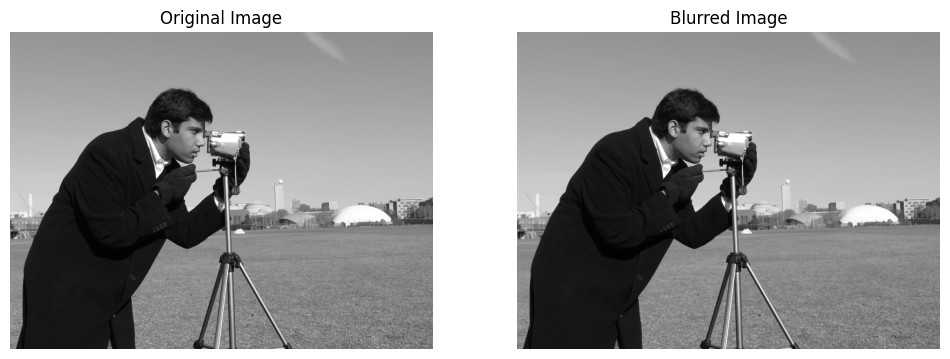

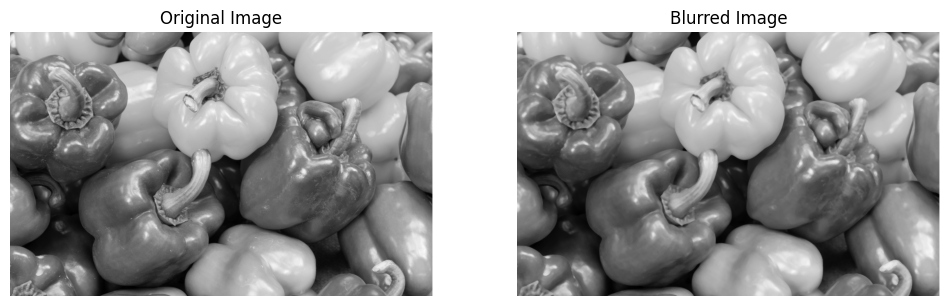

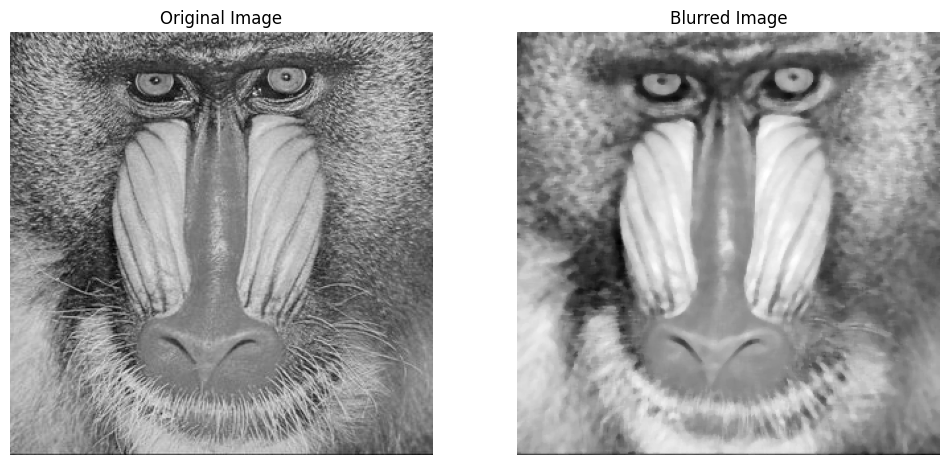

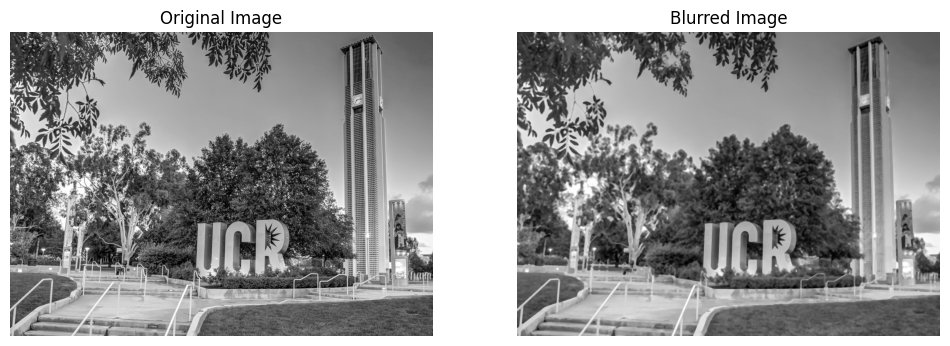

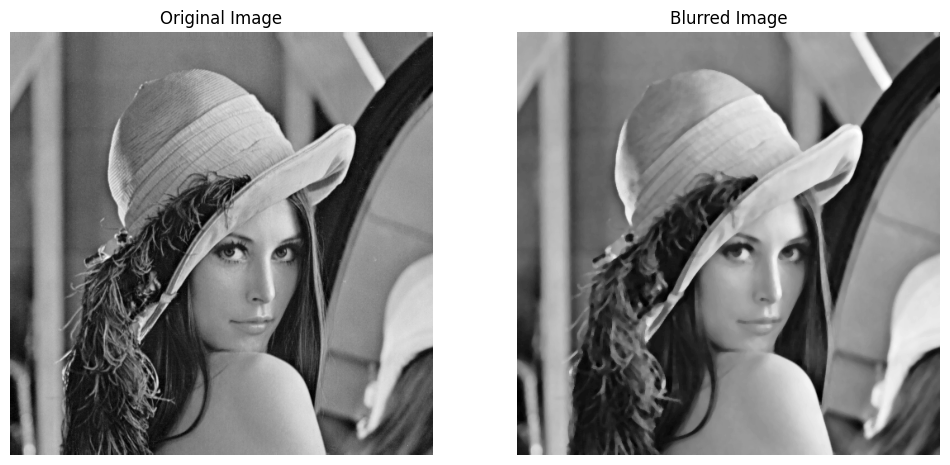

In [277]:
# Display the original and smoothed images side by side

for idx in range(len(og_images)):
  plt.figure(figsize=(12, 12))
  plt.subplot(1, 2, 1)
  plt.imshow(og_images[idx], cmap='gray')
  plt.title('Original Image')
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow(filtered_image_cpu[idx], cmap='gray')
  plt.title('Blurred Image')
  plt.axis('off')
  plt.show()

## **GPU Implemetation with NUMBA**

In [278]:
from numba import cuda
import numpy as np

In [279]:
# Define the median filter kernel
@cuda.jit
def median_filter_kernel(input_image, output_image, ksize):
    # Calculate the thread's absolute position within the grid
    x, y = cuda.grid(2)
    if x >= input_image.shape[0] or y >= input_image.shape[1]:
        return  # Check if x, y coordinates are outside the image

    # Create a small local array to store neighboring pixel values
    local_pixels = cuda.local.array(25, dtype=np.float32)  # Adjust size based on kernel size

    # Fill the local array with neighboring pixel values
    idx = 0
    for i in range(x - ksize, x + ksize + 1):
        for j in range(y - ksize, y + ksize + 1):
            if 0 <= i < input_image.shape[0] and 0 <= j < input_image.shape[1]:
                local_pixels[idx] = input_image[i, j]
                idx += 1

    # Sort the local pixels and find the median
    for i in range(idx):
        for j in range(i + 1, idx):
            if local_pixels[i] > local_pixels[j]:
                # Swap
                local_pixels[i], local_pixels[j] = local_pixels[j], local_pixels[i]

    # Set the median value to the output image
    output_image[x, y] = local_pixels[idx // 2]

In [280]:
# GPU implementation loop
for image in og_images:
    # Transfer the image to the device (GPU memory)
    d_image = cuda.to_device(image)
    d_output = cuda.device_array(image.shape, dtype=np.float32)

    # Kernel configuration
    threadsperblock = (16, 16)
    blockspergrid_x = int(np.ceil(image.shape[0] / threadsperblock[0]))
    blockspergrid_y = int(np.ceil(image.shape[1] / threadsperblock[1]))
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    # Start the timer
    start_time = time.time()

    # Run the kernel
    median_filter_kernel[blockspergrid, threadsperblock](d_image, d_output, 2)  # ksize=2 for a 5x5 kernel

    # Stop the timer
    end_time = time.time()

    # Calculate the runtime
    runtime = end_time - start_time

    # Append runtime to list
    runtime_gpu.append(runtime)

    # Copy result back to host and append to list
    filtered_image_gpu.append(d_output.copy_to_host())

print(f"Number of filter applied to images on GPU: {len(filtered_image_gpu)}")

Number of filter applied to images on GPU: 5


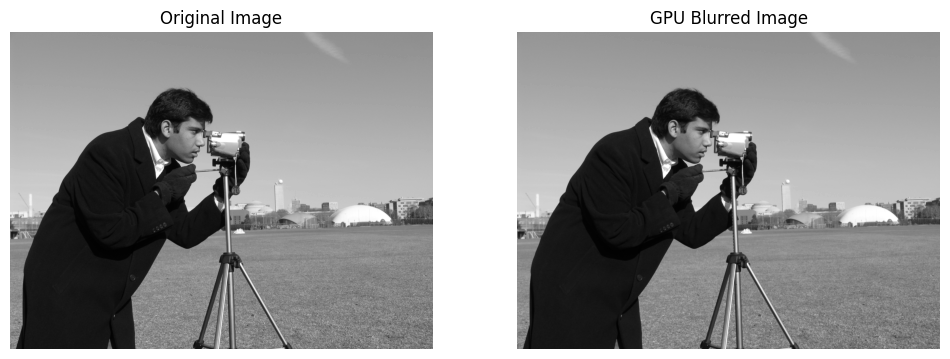

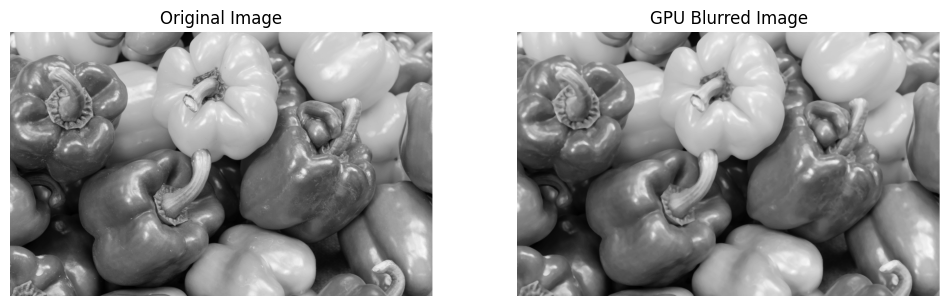

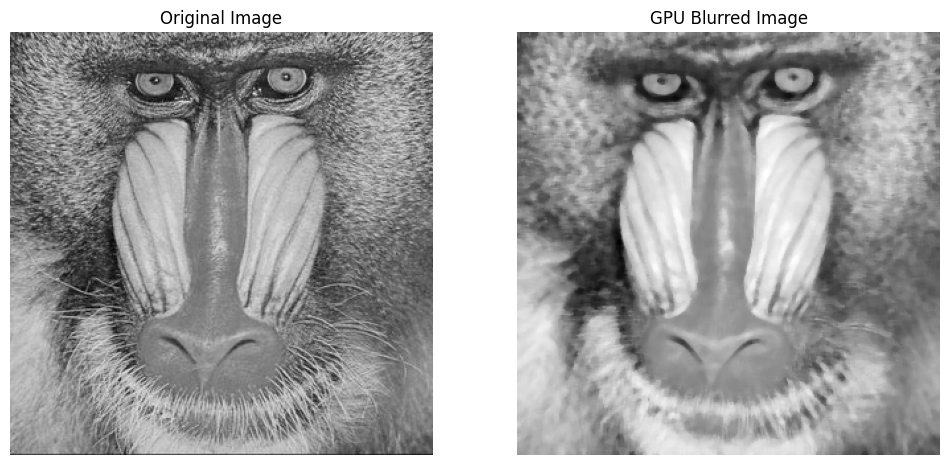

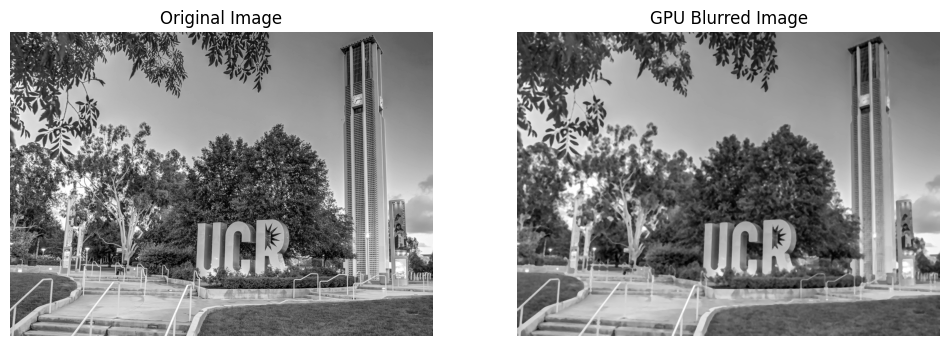

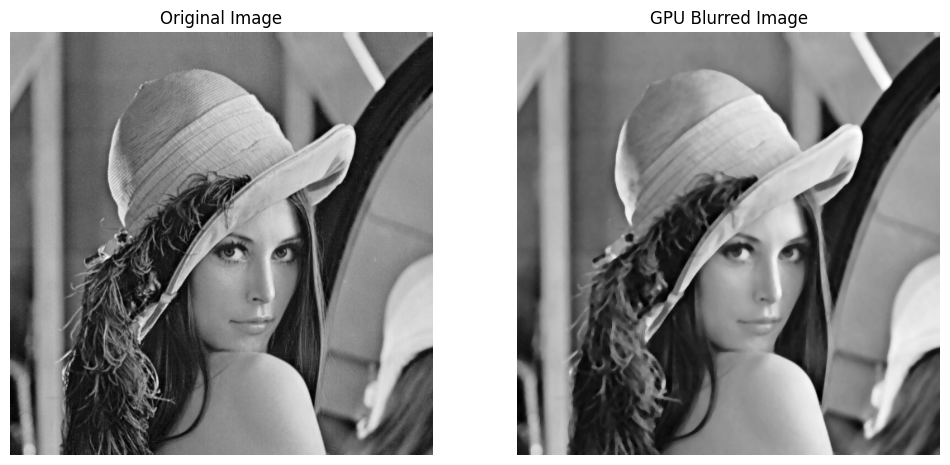

In [281]:
for idx in range(len(og_images)):
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 2, 1)
    plt.imshow(og_images[idx], cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(filtered_image_gpu[idx], cmap='gray')
    plt.title('GPU Blurred Image')
    plt.axis('off')
    plt.show()

## **Plot runtime graphs**

### Line Graph

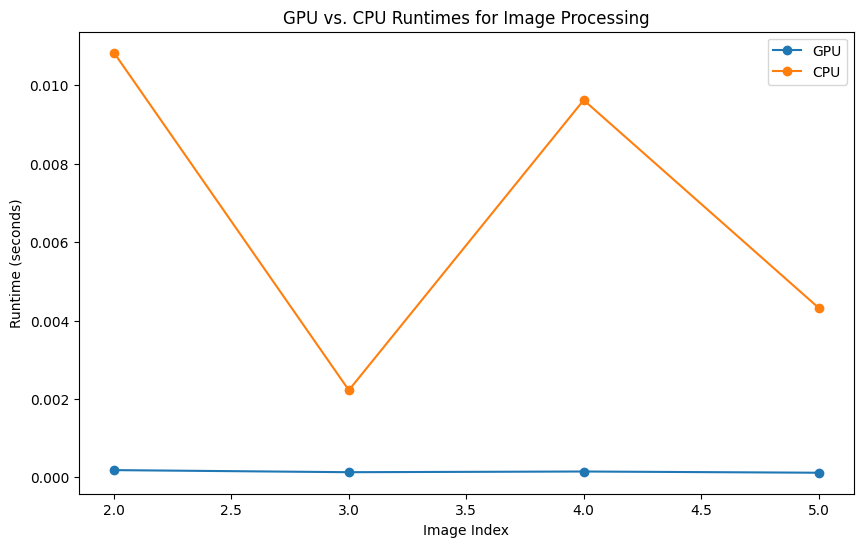

In [282]:
num_images = len(runtime_gpu)

# Exclude the first image from the indices and runtime arrays
image_indices = range(2, num_images + 1)
runtime_gpu = runtime_gpu[1:]
runtime_cpu = runtime_cpu[1:]

# Plotting the runtimes for GPU and CPU
plt.figure(figsize=(10, 6))
plt.plot(image_indices, runtime_gpu, label='GPU', marker='o')
plt.plot(image_indices, runtime_cpu, label='CPU', marker='o')

# Adding labels and title
plt.xlabel('Image Index')
plt.ylabel('Runtime (seconds)')
plt.title('GPU vs. CPU Runtimes for Image Processing')
plt.legend()  # Show legend

# Display the plot
plt.show()


### Line Graph with Logarithmic Y axis

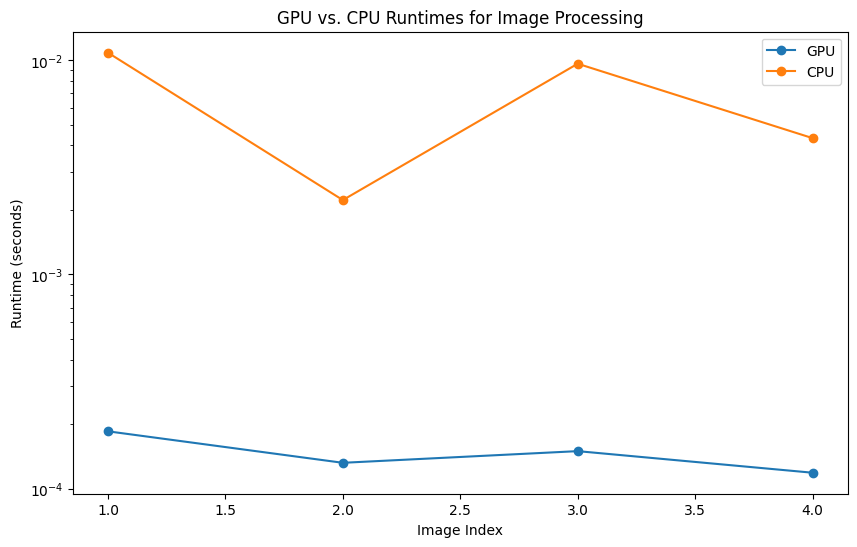

In [283]:
# Number of images
num_images = len(runtime_gpu)

# X-axis representing the index of each image
image_indices = range(1, num_images + 1)

# Plotting the runtimes for GPU and CPU with a logarithmic y-axis scale
plt.figure(figsize=(10, 6))
plt.plot(image_indices, runtime_gpu, label='GPU', marker='o')
plt.plot(image_indices, runtime_cpu, label='CPU', marker='o')

# Adding labels and title
plt.xlabel('Image Index')
plt.ylabel('Runtime (seconds)')
plt.yscale('log')  # Use a logarithmic y-axis scale
plt.title('GPU vs. CPU Runtimes for Image Processing')
plt.legend()  # Show legend

# Display the plot
plt.show()

### Bar Graph with logarithmic Y axis

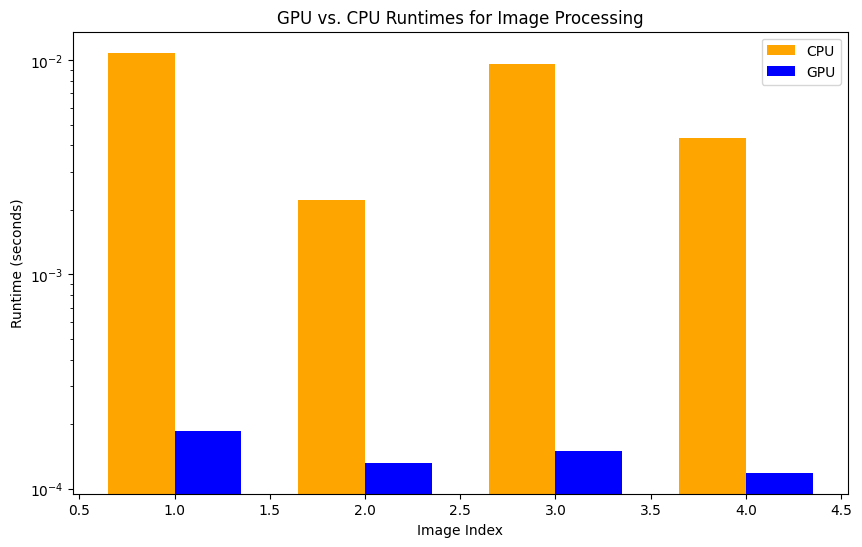

In [286]:
plt.figure(figsize=(10, 6))

# Bar width for better visibility
bar_width = 0.35

# Bar positions for CPU and GPU
bar_positions_cpu = [i - bar_width / 2 for i in image_indices]
bar_positions_gpu = [i + bar_width / 2 for i in image_indices]

# Plotting bars for CPU and GPU
plt.bar(bar_positions_cpu, runtime_cpu, width=bar_width, label='CPU', color='orange')
plt.bar(bar_positions_gpu, runtime_gpu, width=bar_width, label='GPU', color='blue')

# Adding labels and title
plt.xlabel('Image Index')
plt.ylabel('Runtime (seconds)')
plt.yscale('log')  # Use a logarithmic y-axis scale
plt.title('GPU vs. CPU Runtimes for Image Processing')
plt.legend()  # Show legend

# Display the plot
plt.show()